# Inspection of data from the Deutscher Wetter Dienst (german weather service)

## Collecting data on stations

In [22]:
from six.moves import urllib
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
dwd_station_url = "https://www.dwd.de/DE/leistungen/klimadatendeutschland/statliste/statlex_html.html?view=nasPublication&nn=16102"

res = urllib.request.urlopen(dwd_station_url)
print("HTML code:", res.code)

HTML code: 200


In [3]:
file_path = "../data/dwd_stations.html"

print("Writing content to", file_path)
with open(file_path, "w") as f:
    content = res.read().decode("utf-8")
    
    f.write(content)

Writing content to ../data/dwd_stations.html


**Parsing html file**

In [117]:
file_path = "../data/dwd_stations.html"

print("Reading", file_path)
with open(file_path, "r") as f:
    content = f.readlines()
    
soup = BeautifulSoup("".join(content))

Reading ../data/dwd_stations.html


In [118]:
table = soup.find_all("tr")

columns = [e.text for e in table[1] if e.name == "th"]
station_data = pd.DataFrame(columns=columns)

for i,row in enumerate(table[2:]):
    
    if i % 1000 == 0: 
        print("Processed {:.2f} %".format(i/(len(table)-2)*100))
        
    values = [e.text for e in row.find_all("td")]
    
    station_data.loc[i] = values
    
station_data.head()

Processed 0.00 %
Processed 5.31 %
Processed 10.62 %
Processed 15.94 %
Processed 21.25 %
Processed 26.56 %
Processed 31.87 %
Processed 37.19 %
Processed 42.50 %
Processed 47.81 %
Processed 53.12 %
Processed 58.44 %
Processed 63.75 %
Processed 69.06 %
Processed 74.37 %
Processed 79.69 %
Processed 85.00 %
Processed 90.31 %
Processed 95.62 %


,Stationsname,Stations_ID,Kennung,Stations-kennung,Breite,Länge,Stations-höhe,Flussgebiet,Bundesland,Beginn,Ende
0,Aach,1,KL,02783,47.841,8.849,478,,BW,01.01.1937,30.06.1986
1,Aach,1,RR,70191,47.841,8.849,478,,BW,01.01.1912,30.06.1986
2,Aach/Hegau,10771,PE,10771,47.85,8.85,480,,BW,,
3,Aachen,3,EB,02205,50.7827,6.0941,202,803100,NW,01.01.1951,31.03.2011
4,Aachen,3,FF,02205,50.7827,6.0941,202,803100,NW,01.01.1937,31.03.2011


**Doing some tidying up**

In [114]:
pattern = r'^[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]' # string begins with a special character
station_data.replace(to_replace={"Beginn": pattern, "Ende": pattern, "Flussgebiet": pattern}, 
                     regex=True, value='', inplace=True)

In [ ]:
schema = {
    "Stationsname": str, 
    "Stations_ID": str, 
    "Kennung": str,
    "Stations-kennung": str,
    "Breite": float,
    "Länge": float,
    "Stations-höhe": float,
    "Flussgebiet": int,
    "Bundesland": str,
    "Beginn": str,
    "Ende": str
}

for key, var_type in schema.items():
    station_data[key] = station_data[key].apply(var_type)

In [115]:
file_path = "../data/dwd_stations.csv"
print("Writing content to", file_path)
station_data.to_csv(file_path, index=False, sep=",")

Writing content to ../data/dwd_stations.csv


## Analyzing data on stations

In [7]:
file_path = "../data/dwd_stations.csv"

schema = {
    "Stationsname": str, 
    "Stations_ID": str, 
    "Kennung": str,
    "Stations-kennung": str,
    "Breite": float,
    "Länge": float,
    "Stations-höhe": float,
    "Flussgebiet": 'Int64',
    "Bundesland": str,
    "Beginn": str,
    "Ende": str
}

station_data = pd.read_csv(file_path, sep=",", dtype=schema)

station_data["Beginn"] = station_data["Beginn"].apply(pd.to_datetime)
station_data["Ende"] = station_data["Ende"].apply(pd.to_datetime)

station_data.head()

,Stationsname,Stations_ID,Kennung,Stations-kennung,Breite,Länge,Stations-höhe,Flussgebiet,Bundesland,Beginn,Ende
0,Aach,1,KL,02783,47.8410,8.8490,478.0,NaN,BW,1937-01-01,1986-06-30
1,Aach,1,RR,70191,47.8410,8.8490,478.0,NaN,BW,1912-01-01,1986-06-30
2,Aach/Hegau,10771,PE,10771,47.8500,8.8500,480.0,NaN,BW,NaT,NaT
3,Aachen,3,EB,02205,50.7827,6.0941,202.0,803100,NW,1951-01-01,2011-03-31
4,Aachen,3,FF,02205,50.7827,6.0941,202.0,803100,NW,1937-01-01,2011-03-31


In [8]:
print(station_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18824 entries, 0 to 18823
Data columns (total 11 columns):
Stationsname        18824 non-null object
Stations_ID         18824 non-null object
Kennung             18824 non-null object
Stations-kennung    18824 non-null object
Breite              18824 non-null float64
Länge               18824 non-null float64
Stations-höhe       18824 non-null float64
Flussgebiet         9984 non-null Int64
Bundesland          18824 non-null object
Beginn              12238 non-null datetime64[ns]
Ende                12238 non-null datetime64[ns]
dtypes: Int64(1), datetime64[ns](2), float64(3), object(5)
memory usage: 1.6+ MB
None


In [10]:
n = 3
num_rows = len(station_data)

for col in station_data.columns.values:
    
    vals = sorted(station_data[col].unique())
    lowest = vals[:n]
    highest = vals[-n:]
    
    s = """
column = '{col}'
    # unique values = {num_unique}
    duplicates = {duplicates:.2f} %
    lowest {n} = {lowest}
    highest {n} = {highest}""".format(col=col, num_unique=station_data[col].nunique(), n=n, lowest=lowest, 
                                      highest=highest, duplicates=(1-len(vals)/num_rows)*100)
    print(s)


column = 'Stationsname'
    # unique values = 12504
    duplicates = 33.57 %
    lowest 3 = ['Aach', 'Aach/Hegau', 'Aachen']
    highest 3 = ['Ülsby', 'Ürzig', 'Üschersdorf']

column = 'Stations_ID'
    # unique values = 12704
    duplicates = 32.51 %
    lowest 3 = ['1', '10', '100']
    highest 3 = ['9997', '9998', '9999']

column = 'Kennung'
    # unique values = 13
    duplicates = 99.93 %
    lowest 3 = ['AE', 'EB', 'EF']
    highest 3 = ['SO', 'SY', 'TU']

column = 'Stations-kennung'
    # unique values = 15219
    duplicates = 19.15 %
    lowest 3 = ['00001', '01007', '01020']
    highest 3 = ['Z002', 'Z003', 'Z004']

column = 'Breite'
    # unique values = 4055
    duplicates = 78.46 %
    lowest 3 = [47.271, 47.339, 47.36]
    highest 3 = [54.923, 55.0, 55.011]

column = 'Länge'
    # unique values = 4392
    duplicates = 76.67 %
    lowest 3 = [5.907, 5.983, 6.0]
    highest 3 = [14.982999999999999, 15.007, 15.033]

column = 'Stations-höhe'
    # unique values = 913
    dupl

E:\Programs\Anaconda3\envs\py37_tf\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


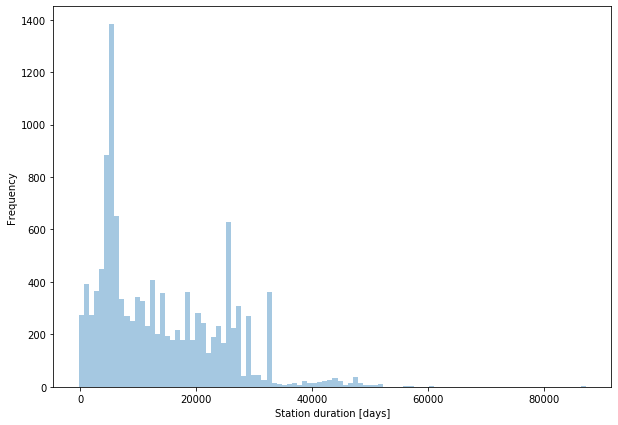

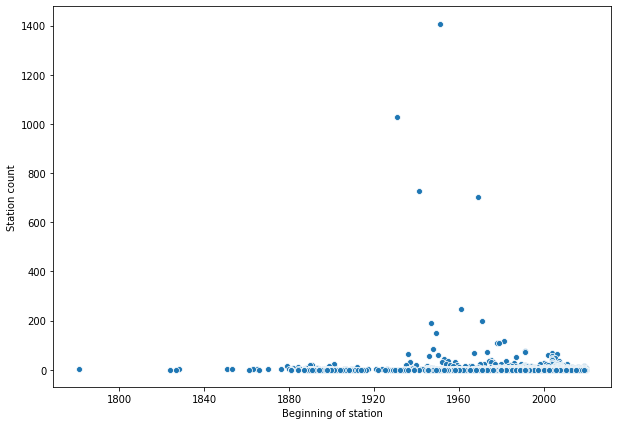

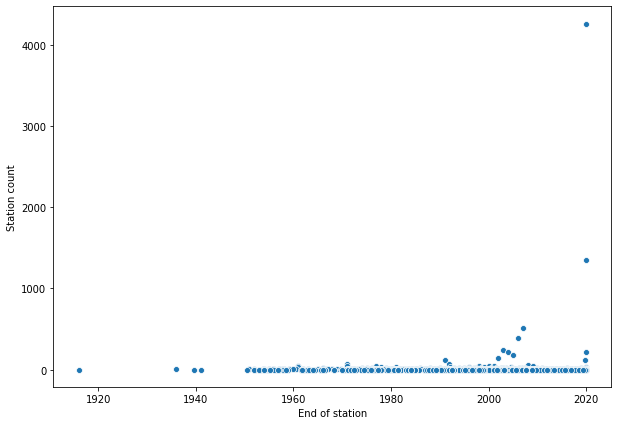

In [40]:
# print(station_data["Beginn"].value_counts())

beginnings = station_data["Beginn"].value_counts()
endings = station_data["Ende"].value_counts()
deltas = (station_data["Ende"] - station_data["Beginn"]).dropna().astype("timedelta64[D]")

fig, ax = plt.subplots(figsize=(10,7))
sns.distplot(deltas, ax=ax, kde=False, bins=100)
ax.set_xlabel("Station duration [days]")
ax.set_ylabel("Frequency")
plt.show()

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(beginnings.index, beginnings.values, ax=ax)
ax.set_xlabel("Beginning of station")
ax.set_ylabel("Station count")
plt.show()

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(endings.index, endings.values, ax=ax)
ax.set_xlabel("End of station")
ax.set_ylabel("Station count")
plt.show()

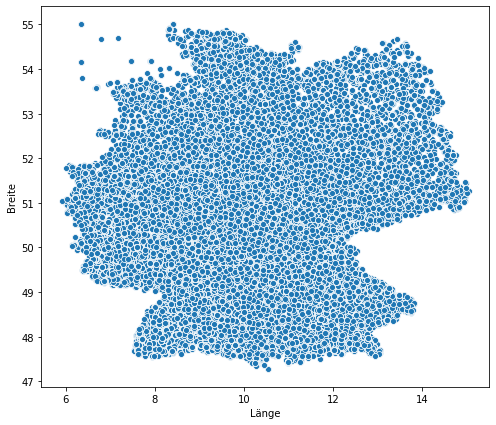

In [43]:
fig, ax = plt.subplots(figsize=(10,7),  )
sns.scatterplot(x="Länge", y="Breite", data=station_data, ax=ax)
ax.set_aspect("equal")
plt.show()

Help on function read_csv in module pandas.io.parsers:

read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)
    Read a comma-separated values (csv) file into DataFrame.
    
    Also supports option

In [ ]:
# distinct_station_names = 